# Gaze Fixation Density Maps / Wooding maps

## GFDM / Wooding maps

## Work

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
#import Pillow
import matplotlib as mplt
from PIL import Image


In [2]:
import os
import shutil

def move_images_to_total(directory, total_images_dir):
    # Créer le répertoire TotalImages s'il n'existe pas déjà
    os.makedirs(total_images_dir, exist_ok=True)

    # Parcourir tous les sous-répertoires et fichiers dans le répertoire donné
    for dirpath, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith('.png') or filename.endswith('.jpg'):
                # Chemin complet du fichier source
                source_file = os.path.join(dirpath, filename)
                # Chemin complet du fichier de destination
                destination_file = os.path.join(total_images_dir, filename)
                # Copier l'image dans le répertoire TotalImages
                shutil.copy(source_file, destination_file)
                
# Exemple d'utilisation
train_dir = './MexCulture142/images_train'
validation_dir = './MexCulture142/images_val'
total_images_dir = './MexCulture142/ImageTotal' 
move_images_to_total(train_dir, total_images_dir)
move_images_to_total(validation_dir, total_images_dir)

In [6]:
import os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def calculate_sigma(R= 1200/325, D = 325, alpha = 2):
    return R * D * np.tan(np.radians(alpha)) 

def GFDM(image_path, fixation_path):
    #Charger les données
    #print(image_path, fixation_path)
    image = Image.open(image_path).convert('L')
    image_array = np.array(image)
    fixation_points = np.loadtxt(fixation_path)
    
    # creation fixation map
    fixation_map = np.zeros(image_array.shape)

    # formule 1 : A Gaze Fixation Density Map (GFDM)
    #print("formule 1")
    for fixation in fixation_points:
        x, y = int(fixation[0]), int(fixation[1]) 
        if 0 <= x < fixation_map.shape[1] and 0 <= y < fixation_map.shape[0]:
            fixation_map[y, x] += 1  
    
    # formule 2 : Gaussian spread 
    #print("formule 2")
    sigma = calculate_sigma()
    
    # formule 3 : The partial saliency map
    #print("formule 3")
    saliency_map = gaussian_filter(fixation_map, sigma=sigma)
    
    # Normalize the saliency map
    saliency_map = saliency_map / np.max(saliency_map)

    # Enregistrer l'image en niveaux de gris
    #print("save grayscale")
    saliency_image = Image.fromarray(np.uint8(saliency_map * 255))
    saliency_image.save(f"./MexCulture142/saliency/{os.path.basename(image_path)}")
    
    # Enregistrer l'image en couleur
    #print("save color")
    plt.imshow(image_array, cmap='gray')
    plt.imshow(saliency_map, cmap='jet', alpha=0.5)  # Overlay with color map
    plt.axis('off')
    plt.savefig(f"./MexCulture142/color_mapped/{os.path.basename(image_path)}", bbox_inches='tight', pad_inches=0)
    plt.close()
    
#GFDM("./MexCulture142/ImageTotal/Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_N_1.png", "./MexCulture142/fixations/Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_GazeFix_N_1.txt")

In [7]:
# load Images
def LoadData(directoryImage, directoryFixation):
    for filename in os.listdir(directoryImage):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            if '_N_1' in filename :
                name = filename.split('_N_1')[0]
                fixation_path =  os.path.join(directoryFixation, name + '_GazeFix_N_1.txt')
            if '_N_2' in filename :
                name = filename.split('_N_2')[0]
                fixation_path =  os.path.join(directoryFixation, name + '_GazeFix_N_2.txt')
            images_path=os.path.join(directoryImage,filename)
            GFDM(images_path, fixation_path)

# Charger les images des répertoires d'entraînement et de validation
fixation_dir = './MexCulture142/fixations' 
X = LoadData(total_images_dir,fixation_dir )

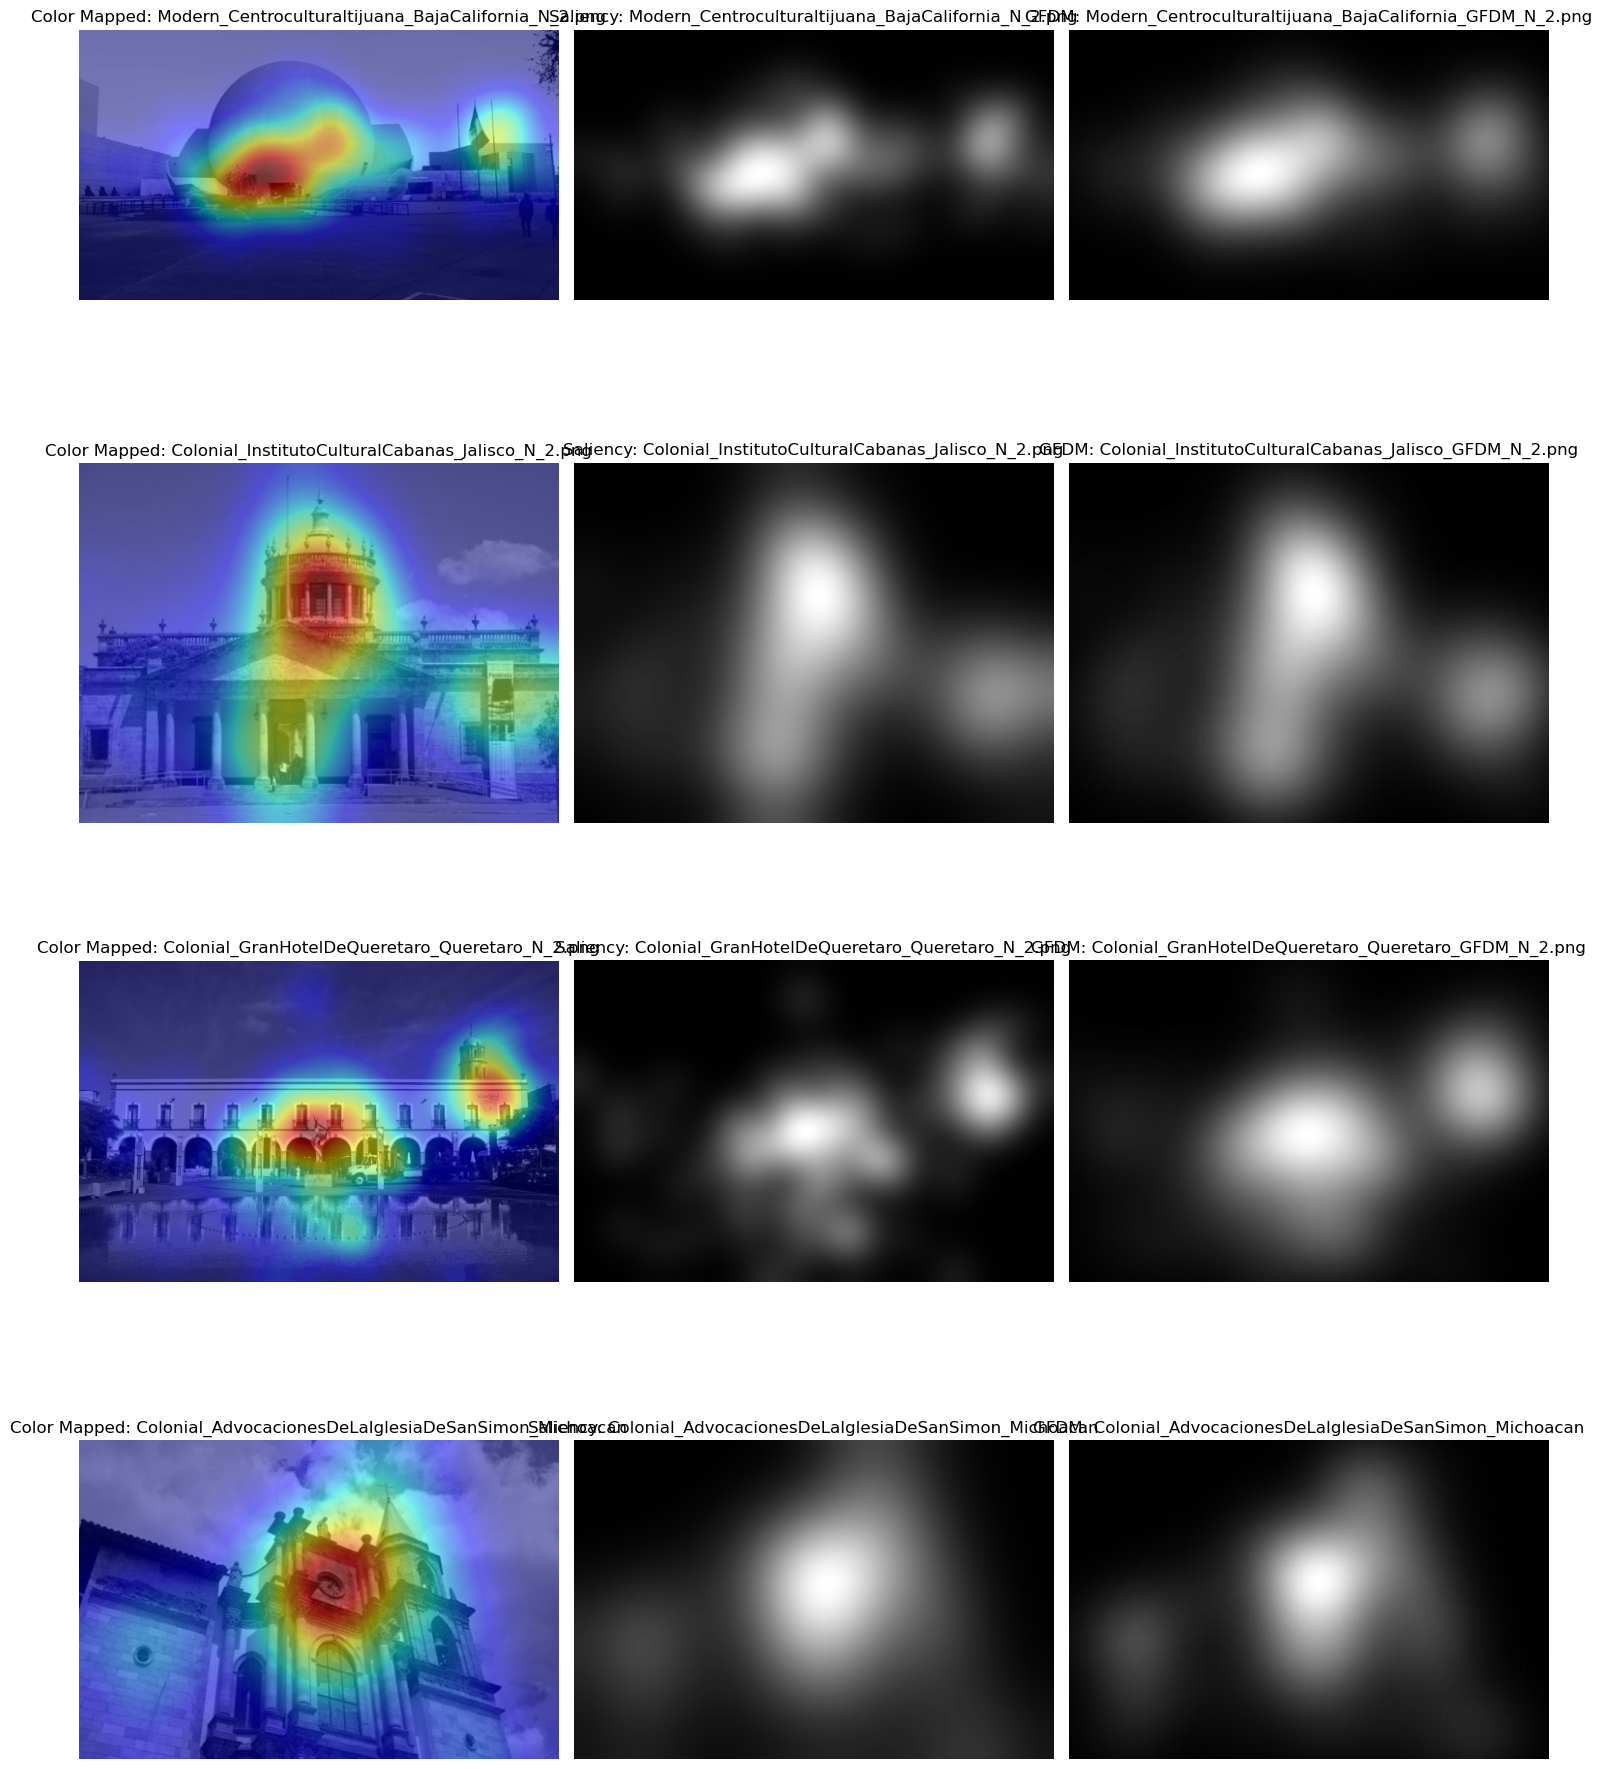

In [8]:
color_mapped_dir = './MexCulture142/color_mapped'
saliency_dir = './MexCulture142/saliency'
gaze_fixation_density_maps_dir = './MexCulture142/gazefixationsdensitymaps'

# Obtenir les listes d'images des trois dossiers
color_mapped_images = [f for f in os.listdir(color_mapped_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:3]
saliency_images = [f for f in os.listdir(saliency_dir) if f.endswith(('.png', '.jpg', '.jpeg'))][:3]

# Charger et afficher les images
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # Ajusté pour 4 lignes

for i in range(3):
    # Charger les images
    color_mapped_image = Image.open(os.path.join(color_mapped_dir, color_mapped_images[i]))
    saliency_image = Image.open(os.path.join(saliency_dir, saliency_images[i]))
    
    # Déterminer le nom du fichier GFDM
    gaze_fixation_density_maps_images = ''
    if '_N_1' in saliency_images[i]:
        name = saliency_images[i].split('_N_1')[0]
        gaze_fixation_density_maps_images = name + '_GFDM_N_1.png'
    elif '_N_2' in saliency_images[i]:
        name = saliency_images[i].split('_N_2')[0]
        gaze_fixation_density_maps_images = name + '_GFDM_N_2.png'
    
    # Charger l'image GFDM
    gaze_fixation_density_map_image = Image.open(os.path.join(gaze_fixation_density_maps_dir, gaze_fixation_density_maps_images))
    
    # Afficher les images
    axes[i, 0].imshow(color_mapped_image)
    axes[i, 0].set_title(f'Color Mapped: {color_mapped_images[i]}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(saliency_image, cmap='gray')
    axes[i, 1].set_title(f'Saliency: {saliency_images[i]}')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(gaze_fixation_density_map_image, cmap='gray')
    axes[i, 2].set_title(f'GFDM: {gaze_fixation_density_maps_images}')
    axes[i, 2].axis('off')

# Charger et afficher une image supplémentaire
color_mapped_image = Image.open(os.path.join(color_mapped_dir, 'Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_N_1.png'))
saliency_image = Image.open(os.path.join(saliency_dir, 'Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_N_1.png'))
gaze_fixation_density_map_image = Image.open(os.path.join(gaze_fixation_density_maps_dir, 'Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_GFDM_N_1.png'))

axes[3, 0].imshow(color_mapped_image)
axes[3, 0].set_title("Color Mapped: Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan")
axes[3, 0].axis('off')

axes[3, 1].imshow(saliency_image, cmap='gray')
axes[3, 1].set_title("Saliency: Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan")
axes[3, 1].axis('off')

axes[3, 2].imshow(gaze_fixation_density_map_image, cmap='gray')
axes[3, 2].set_title("GFDM: Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan")
axes[3, 2].axis('off')

plt.tight_layout()
plt.show()
